# Hierarchical Bayesian Models with Dynamical Systems

## Outline


TODO: revise 

- [Setup](#setup)

- [Overview: Causal Inference in Continuous Time Dynamical Systems](#overview:-causal-inference-in-continuous-time-dynamical-systems)
    - [Task: Modeling Causal Interventions in Continuous Time Systems](#task:-modeling-causal-interventions-in-continuous-time-systems)
    - [Challenge: Representational Complexities of ODEs in Causal Inference](#challenge:-representational-complexities-of-odes-in-causal-inference)
    - [Assumptions: Deterministic Dynamics and No Latent Confounders](#assumptions:-deterministic-dynamics-and-no-latent-confounders)
    - [Intuition: Understanding Interventions in Dynamical Systems](#intuition:-understanding-interventions-in-dynamical-systems)

- [References](#references)


## Setup

Here, we install the necessary Pytorch, Pyro, and ChiRho dependencies for this example.

In [1]:
%reload_ext autoreload
%autoreload 2

import warnings

warnings.filterwarnings("ignore")

import os
import matplotlib.pyplot as plt
import pyro
import pyro.distributions as dist
import seaborn as sns
import torch
from pyro.infer import Predictive
from pyro.infer.autoguide import AutoLowRankMultivariateNormal, AutoMultivariateNormal


from chirho.dynamical.handlers import (
    LogTrajectory,
    StaticBatchObservation,
    StaticIntervention,
)
from chirho.dynamical.handlers.solver import TorchDiffEq
from chirho.dynamical.ops import Dynamics, State, simulate
from chirho.observational.handlers import condition
from chirho.interventional.handlers import do
from chirho.counterfactual.handlers import MultiWorldCounterfactual
from chirho.indexed.ops import IndexSet, gather, indices_of

pyro.settings.set(module_local_params=True)

sns.set_style("white")

# Set seed for reproducibility
seed = 123
pyro.clear_param_store()
pyro.set_rng_seed(seed)

smoke_test = "CI" in os.environ
num_steps = 10 if smoke_test else 200
num_samples = 10 if smoke_test else 500

In [2]:
# plotting functions

line_styles = ["solid", "dashed", "dotted", "dashdot"]
colors = {"S": "blue", "I": "red", "R": "green"}


def SIR_uncertainty_plot(time_period, state_pred, color, ax, linestyle="solid"):
    sns.lineplot(
        x=time_period,
        y=state_pred.mean(dim=0) if state_pred.ndim > 1 else state_pred,
        color=color,
        linestyle=linestyle,
        ax=ax,
    )

    if state_pred.ndim > 1:
        # 95% Credible Interval
        ax.fill_between(
            time_period,
            torch.quantile(state_pred, 0.025, dim=0),
            torch.quantile(state_pred, 0.975, dim=0),
            alpha=0.2,
            color=color,
            label="95% Credible Interval",
        )


def SIR_peak_plot(true_state, true_logging_times, ax):
    peak_idx = torch.argmax(true_state)
    ax.axvline(true_logging_times[peak_idx], color="red", label="Peak Infection Time")


def SIR_data_plot(time_period, data, data_label, ax, color="black"):
    sns.scatterplot(x=time_period, y=data, color=color, ax=ax, label=data_label)


def SIR_test_plot(test_start_time, test_end_time, ax):
    ax.axvline(
        test_start_time, color="black", linestyle=":", label="Measurement Period"
    )
    ax.axvline(test_end_time, color="black", linestyle=":")


def plot_sir_data(
    n_strata,
    colors,
    sir_traj=None,
    logging_times=None,
    sir_data=None,
    obs_logging_times=None,
    true_traj=None,
    true_logging_times=None,
    plot_true_peak=False,
    main_title=None,
):

    fig, ax = plt.subplots(n_strata, 3, figsize=(15, 5), sharex=True, sharey=True)

    if main_title is not None:
        fig.suptitle(main_title, fontsize=16)

    if sir_data is not None:
        SIR_data_plot(
            obs_logging_times,
            sir_data["I_obs"],
            color=colors["I"],
            ax=ax[0, 1],
            data_label=None,
        )

    if true_traj is not None:
        for i in range(n_strata):

            for j, key in enumerate(["S", "I", "R"]):
                SIR_uncertainty_plot(
                    true_logging_times,
                    true_traj[key][i, :],
                    color="black",
                    ax=ax[i, j],
                    linestyle="dashed",
                )

            if plot_true_peak:
                SIR_peak_plot(true_traj["I"][i, :], true_logging_times, ax[i, 1])

    if sir_traj is not None:
        for i in range(n_strata):

            for j, key in enumerate(["S", "I", "R"]):
                SIR_uncertainty_plot(
                    logging_times,
                    sir_traj[key][..., 0, i, :],
                    color=colors[key],
                    ax=ax[i, j],
                )

    # Set x-axis labels
    ax[i, 0].set_xlabel("Time (months)")
    ax[i, 1].set_xlabel("Time (months)")
    ax[i, 2].set_xlabel("Time (months)")

    for i in range(n_strata):
        if i == 0:
            ax[i, 0].set_title("Susceptible")
            ax[i, 1].set_title("Infected")
            ax[i, 2].set_title("Recovered")

        ax_right_2 = ax[i, 2].twinx()
        ax_right_2.set_ylabel(f"Town {i}", rotation=270, labelpad=15)
        ax_right_2.yaxis.set_label_position("right")
        ax_right_2.tick_params(right=False)
        ax_right_2.set_yticklabels([])

    ax[0, 0].set_ylabel("")
    ax[2, 0].set_ylabel("")
    ax[1, 0].set_ylabel("Number of individuals (thousands)")

    plt.tight_layout()
    plt.show()



def plot_marginals(
    beta_mean,
    gamma_mean,
    betas,
    gammas,
    beta_true,
    gamma_true,
    title,
    xlim=None,
    ylim=None,
    bw_adjust=1,
):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))

    sns.kdeplot(
        beta_mean,
        ax=ax[0],
        color="gray",
        label="mean $\\beta$",
        linewidth=3,
        bw_adjust=bw_adjust,
    )

    town_colors = ["blue", "green", "purple"]
    for loc, beta in enumerate(betas):

        sns.kdeplot(
            beta,
            ax=ax[0],
            alpha=0.4,
            color=town_colors[loc],
            label=f"town {loc} $\\beta$",
            linewidth=1.5,
            bw_adjust=bw_adjust,
        )

        ax[0].axvline(
            beta_true[loc],
            color=town_colors[loc],
            label=f"town {loc} ground truth",
            linestyle="--",
        )

    ax[0].legend()

    sns.kdeplot(
        gamma_mean,
        ax=ax[1],
        color="gray",
        label="mean $\\gamma$",
        linewidth=3,
        bw_adjust=bw_adjust,
    )
    for loc, gamma in enumerate(gammas):
        sns.kdeplot(
            gamma,
            ax=ax[1],
            alpha=0.4,
            color=town_colors[loc],
            label=f"town {loc} $\\gamma$",
            linewidth=1.5,
            bw_adjust=bw_adjust,
        )
        ax[1].axvline(
            gamma_true[loc],
            color=town_colors[loc],
            label=f"town {loc} ground truth",
            linestyle="--",
        )

    ax[1].legend()

    if xlim is not None:
        ax[0].set_xlim(xlim)
        ax[1].set_xlim(xlim)

    if ylim is not None:
        ax[0].set_ylim(ylim)
        ax[1].set_ylim(ylim)

    fig.suptitle(title, fontsize=16)

    fig.tight_layout()
    sns.despine()
    fig.show()

## Overview: Composing Hierarchical Bayesian Models with ODEs

In our previous tutorial on causal reasoning with continuous time dynamical systems we showed how embedding differential equation solvers in ChiRho allows us to do the following: (i) fit dynamical systems parameters using Pyro's support for variational inference and (ii) reason about (uncertain) interventions representing various policy decisions. In this tutorial we expand on that early epidemiological example by composing the same simple susceptible, infected, recovered (SIR) model with hierarchical priors over dynamical systems parameters for each of several distinct geographic location (we will use three locations in our running example). The key insight here is that the same Bayesian modeling motifs for pooling statistical information between distinct strata in standard Bayesian multilevel regression modeling (see Chapter 5 of Gelman, A., Carlin, J. B., Stern, H. S., & Rubin, D. B. (1995). *Bayesian data analysis*. Chapman and Hall/CRC with subsequent editions and improvements) can be used when the regression equations are swapped out with mechanistic models in the form of differential equations. We will also see that such effects carry over to the predicted effects of interventions. 

### Background: causal reasoning in dynamical systems

If you haven't read the preliminary tutorial on causal reasoning with continuous time dynamical systems, we recommend doing so first beforing continuing. In that tutorial you'll find a short description of how we represent causal interventions in dynamical systems, as well as all of the details behind the SIR model used in this expanded tutorial.

### Modelling assumptions:

In this example, we again explore the SIR (Susceptible, Infected, Recovered) compartmental model, a fundamental model in epidemiology. Here, the variables of interest are:

- $S(t)$: the number of susceptible individuals at time $t$,

- $I(t)$: the number of infected individuals at time $t$, and

- $R(t)$: the number of recovered individuals at time $t$.

These compartments interact through a set of ordinary differential equations that describe the rate at which individuals move from being susceptible to infected, and from infected to recovered. 

Unlike in the previous tutorial, where $S$, $I$, and $R$ are real-valued functions of time, in this tutorial these variables will be vector-valued functions of time where each element corresponds to the number of people susceptible, infected, and recovered in a particular stratum. In this example, each stratum refers to an individual town. We will assume the interactions between compartments within each of the towns are guided by the same equations with potentially somewhat different parameters, coming from (respectively) the same common distributions. 

We will also assume that parameters come from distributions representing our uncertainty about them, and that observations come from Poisson distributions centered around predicted trajectories. In practice, this will be achieved by composing the ODE core with Bayesian elements in a step-wise fashion as described below.

## Causal probabilistic program

Just as in the previous tutorial, we define the differential equation model as a `pyro.nn.PyroModule` as follows, where the forward method is a function from states `X` to the time derivatives of the states, `dX`. Fortunately, we can use the exact same implementation for the stratified example here, taking advantage of PyTorch's tensor broadcasting semantics.

Also, we assume we only make observations in one of the locations, which - intuitively - should decrease our uncertaintly about that location more than about other locations, while still allowing us learn something about them, in virtue of the location-specific parameters coming from the same general distributions. Conceptually, `single_observation_model()` takes a trajectory already produced by a simulation, and generates a sample of Poisson-distributed observations at the first location.

In [3]:
class SIRDynamics(pyro.nn.PyroModule):
    def __init__(self, beta, gamma):
        super().__init__()
        self.beta = beta
        self.gamma = gamma

    def forward(self, X: State[torch.Tensor]):
        dX = dict()
        dX["S"] = -self.beta * X["S"] * X["I"]
        dX["I"] = self.beta * X["S"] * X["I"] - self.gamma * X["I"]
        dX["R"] = self.gamma * X["I"]
        return dX


def sir_observation_model(X: State[torch.Tensor]) -> None:
    # Note: Here we set the event_dim to 1 if the last dimension of X["I"] is > 1, as the sir_observation_model
    # can be used for both single and multi-dimensional observations.
    event_dim = 1 if X["I"].shape and X["I"].shape[-1] > 1 else 0
    pyro.sample(
        "I_obs", dist.Poisson(X["I"]).to_event(event_dim)
    )  # noisy number of infected actually observed
    pyro.sample(
        "R_obs", dist.Poisson(X["R"]).to_event(event_dim)
    )  # noisy number of recovered actually observed


def single_observation_model(X: State[torch.Tensor]) -> None:
    # In this example we only take noisy measurements of a single town corresponding to
    # the first index in the state tensors (0 in the second-last dimension, the last dimension is time).
    first_X = {k: v[..., 0, :] for k, v in X.items()}
    return sir_observation_model(first_X)

To use this model definition in a stratified setting, we simply extend the tensor dimensions of the `init_state` as follows. We generate the ground truth trajectories, as well as trajectories logged at observation times, passed on to the `single_observation_model()` to generate synthetic data used further on.

In [4]:
n_strata = 3

# Assume that in each town there is initially a population of 99 thousand people that are susceptible,
# 1 thousand infected, and 0 recovered.
init_state = dict(
    S=torch.ones(n_strata) * 99, I=torch.ones(n_strata), R=torch.zeros(n_strata)
)
start_time = torch.tensor(0.0)
end_time = torch.tensor(6.0)
step_size = torch.tensor(0.1)
logging_times = torch.arange(start_time, end_time, step_size)

# We now simulate from the SIR model. Notice that the true parameters are similar to each other,
# but not exactly the same.
beta_true = torch.tensor([0.03, 0.04, 0.035])
gamma_true = torch.tensor([0.4, 0.385, 0.405])
sir_true = SIRDynamics(beta_true, gamma_true)
with TorchDiffEq(), LogTrajectory(logging_times) as lt:
    simulate(sir_true, init_state, start_time, end_time)

sir_true_traj = lt.trajectory

obs_start_time = torch.tensor(0.5)  # Measurements start 0.5 months into the pandemic
obs_sample_rate = torch.tensor(1 / 7)  # Take measurements once per week
obs_end_time = torch.tensor(6.0)  # Measurements end after 6th month

obs_logging_times = torch.arange(obs_start_time, obs_end_time, obs_sample_rate)
N_obs = obs_logging_times.shape[0]
with TorchDiffEq(), LogTrajectory(obs_logging_times) as lt_obs:
    simulate(sir_true, init_state, start_time, obs_end_time)

sir_obs_traj = lt_obs.trajectory
with pyro.poutine.trace() as tr:
    # Suppose we only observe the number of infected and recovered individuals in the first town.
    single_observation_model(sir_obs_traj)

sir_data = dict(**{k: tr.trace.nodes[k]["value"] for k in ["I_obs", "R_obs"]})

So, as our ground truth, we have the true trajectories for the three compartments, in three locations, with some observations of one compartment in the first locations, as follows:

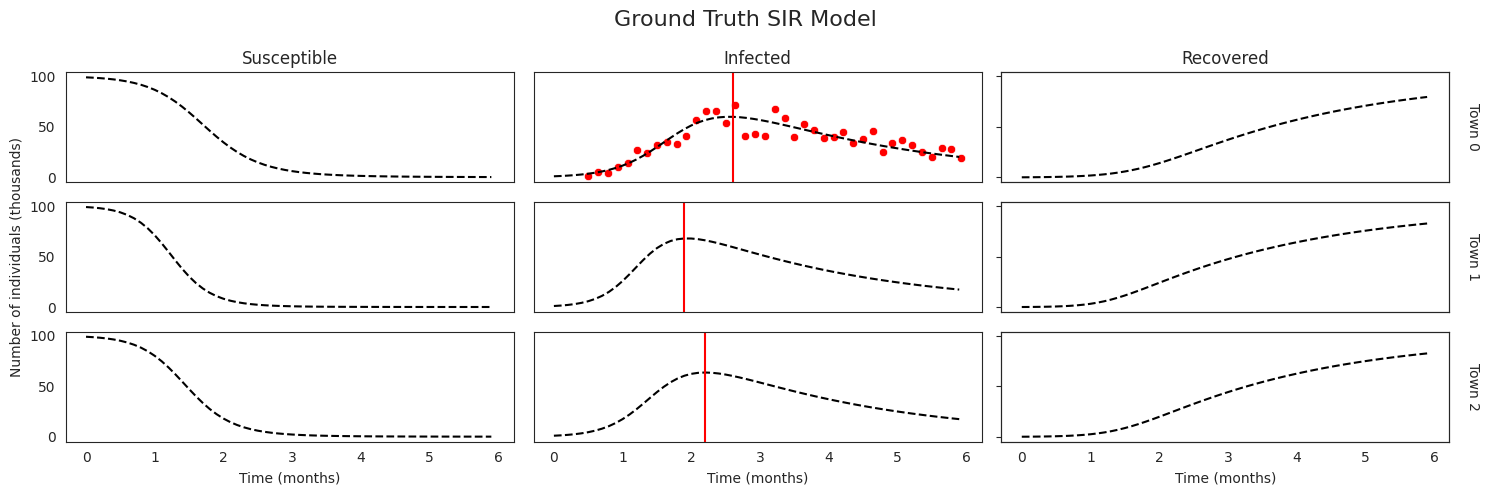

In [5]:
plot_sir_data(
    n_strata,
    colors=colors,
    true_traj=sir_true_traj,
    true_logging_times=logging_times,
    sir_data=sir_data,
    obs_logging_times=obs_logging_times,
    plot_true_peak=True,
    main_title="Ground Truth SIR Model",
)

## Multi-level Bayesian model

Now we introduce a multi-level structure of uncertainty about the parameters. For local parameters we'll be using  Gamma distributions, which - for convenience - we reparametrize in terms of mean and standard deviation. These will be sampled around group-level coefficiens, the uncertainty about which will be expressed in terms of Beta distributions.

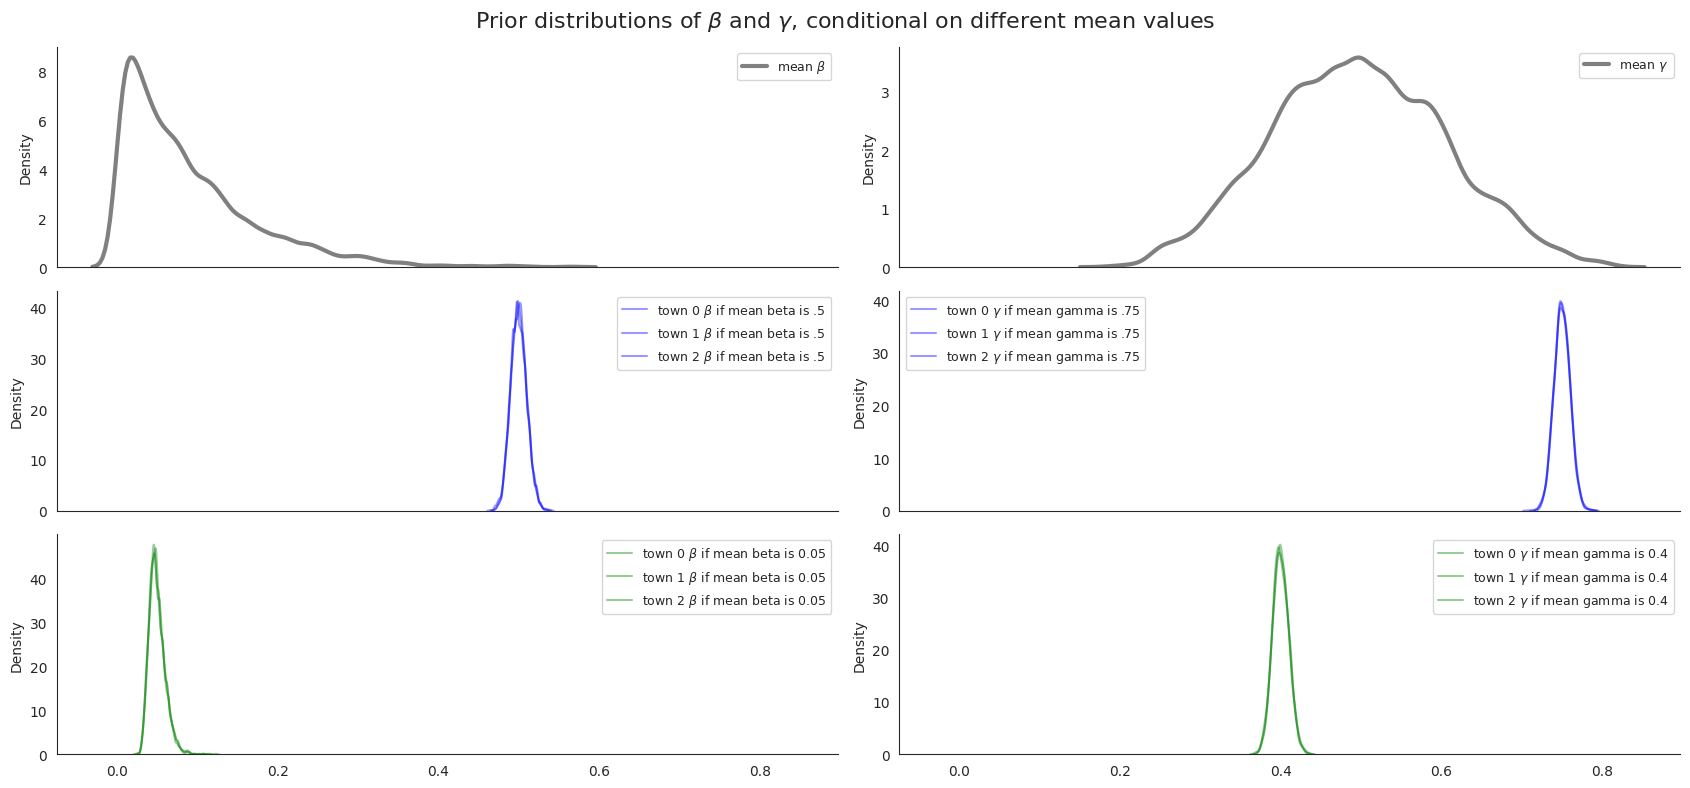

In [6]:
def reparameterize_inverse_gamma(mean, std):
    alpha = 2 + mean**2 / std**2
    beta = mean * (alpha - 1)
    return alpha, beta


def bayesian_multilevel_sir_prior(
    n_strata: int,
) -> tuple[torch.Tensor, torch.Tensor, pyro.plate]:
    beta_mean = pyro.sample("beta_mean", dist.Beta(1, 10))
    beta_std = 0.01

    gamma_mean = pyro.sample("gamma_mean", dist.Beta(10, 10))
    gamma_std = 0.01

    strata_plate = pyro.plate("strata", size=n_strata, dim=-1)

    with strata_plate:
        beta = pyro.sample(
            "beta",
            dist.InverseGamma(*reparameterize_inverse_gamma(beta_mean, beta_std)),
        )
        gamma = pyro.sample(
            "gamma",
            dist.InverseGamma(*reparameterize_inverse_gamma(gamma_mean, gamma_std)),
        )
    return beta, gamma, strata_plate


# let's illustrate prior distributions: they should be similar but not identical
with MultiWorldCounterfactual() as mwc:
    with pyro.poutine.trace() as tr:
        with pyro.plate("samples", num_samples * 5, dim=-2):
            with do(actions={"beta_mean": (torch.tensor(0.5), torch.tensor(0.05)),
                             "gamma_mean": (torch.tensor(0.75), torch.tensor(0.4))}):
                bayesian_multilevel_sir_prior(n_strata)


betas = tr.trace.nodes["beta"]["value"]
gammas = tr.trace.nodes["gamma"]["value"]

beta_mean = tr.trace.nodes["beta_mean"]["value"].squeeze().numpy()
gamma_mean = tr.trace.nodes["gamma_mean"]["value"].squeeze()

with mwc:
    betas_intervention1 = gather(betas, IndexSet(beta_mean={1}, gamma_mean = {1}), event_dim=0).squeeze()
    betas_intervention2 = gather(betas, IndexSet(beta_mean={2}, gamma_mean = {2}), event_dim=0).squeeze()
    
    gammas_intervention1 = gather(gammas, IndexSet(beta_mean={1}, gamma_mean = {1}), event_dim=0).squeeze()
    gammas_intervention2 = gather(gammas, IndexSet(beta_mean={2}, gamma_mean = {2}), event_dim=0).squeeze()


fig, ax = plt.subplots(3, 2, figsize=(17, 8), sharex=True)

sns.kdeplot(
        beta_mean,
        ax=ax[0,0],
        color="gray",
        label="mean $\\beta$",
        linewidth=3,
        bw_adjust=.6,
    )

sns.kdeplot(
        gamma_mean,
        ax=ax[0,1],
        color="gray",
        label="mean $\\gamma$",
        linewidth=3,
        bw_adjust=.6,
    )


for loc, beta in enumerate(betas_intervention1.T):
    sns.kdeplot(
        beta,
        ax=ax[1,0],
        alpha=0.4,
        color="blue",
        label=f"town {loc} $\\beta$ if mean beta is .5",
        linewidth=1.5,
        bw_adjust=.6,
    )

for loc, beta in enumerate(betas_intervention2.T):
    sns.kdeplot(
        beta,
        ax=ax[2,0],
        alpha=0.4,
        color="green",
        label=f"town {loc} $\\beta$ if mean beta is 0.05",
        linewidth=1.5,
        bw_adjust=.6,
    )

for loc, gamma in enumerate(gammas_intervention1.T):
    sns.kdeplot(
        gamma,
        ax=ax[1,1],
        alpha=0.4,
        color="blue",
        label=f"town {loc} $\\gamma$ if mean gamma is .75",
    )

for loc, gamma in enumerate(gammas_intervention2.T):
    sns.kdeplot(
        gamma,
        ax=ax[2,1],
        alpha=0.4,
        color="green",
        label=f"town {loc} $\\gamma$ if mean gamma is 0.4",
    )

size = 9
ax[0,0].legend(prop={'size': size})
ax[0,1].legend(prop={'size': size})
ax[1,0].legend(prop={'size': size})
ax[2,0].legend(prop={'size': size})
ax[1,1].legend(prop={'size': size})
ax[2,1].legend(prop={'size': size})
sns.despine()
plt.suptitle("Prior distributions of $\\beta$ and $\\gamma$, conditional on different mean values", fontsize=16)
plt.tight_layout()
plt.show()




Now we put some components together. First we sample the parameters, then we pass them on to ``TorchDiffEq` to simulate.

In [7]:
def simulated_multilevel_bayesian_sir(
    init_state, start_time, logging_times, base_model=SIRDynamics, is_traced=True
) -> State[torch.Tensor]:
    n_strata = init_state["S"].shape[-1]
    assert init_state["I"].shape[-1] == init_state["R"].shape[-1] == n_strata
    beta, gamma, _ = bayesian_multilevel_sir_prior(n_strata)
    sir = base_model(beta, gamma)
    with TorchDiffEq(), LogTrajectory(logging_times, is_traced=is_traced) as lt:
        simulate(sir, init_state, start_time, logging_times[-1])
    return lt.trajectory

This results in a model with the following structure:

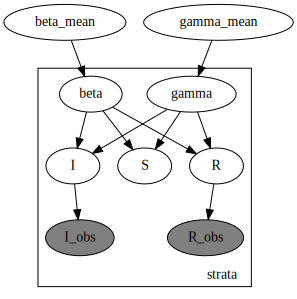

In [8]:
# Note: this is a bit of a hack to render the model.
# For some unknown reason `simulate` does not compose with the model rendering.


def rendering_model(n_strata) -> State[torch.Tensor]:

    beta, gamma, plate = bayesian_multilevel_sir_prior(n_strata)
    sir = SIRDynamics(beta, gamma)
    state = dict(
        S=torch.ones(n_strata) * 99, I=torch.ones(n_strata), R=torch.zeros(n_strata)
    )

    deriv = sir(state)
    state = {k: v + deriv[k] * 0.1 for k, v in state.items()}
    deriv = sir(state)
    state = {k: v + deriv[k] * 0.1 for k, v in state.items()}
    with plate:
        state = {k: pyro.sample(k, dist.Delta(v)) for k, v in state.items()}

        with pyro.condition(
            data={"I_obs": torch.ones(n_strata), "R_obs": torch.zeros(n_strata)}
        ):
            sir_observation_model(state)


# Note: this only works with Pyro 1.9.0. This will need to wait until ChiRho is updated to Pyro 1.9.0.
pyro.render_model(rendering_model, model_args=(3,), render_deterministic=True)

We can also inspect prior predictions, by generating the samples. Note how the shape of the sample, with some padding, captures the number of samples, the numer of locations, and the number of logging times, respectively. We just add the prior credible interals to the illustration we've already seen.

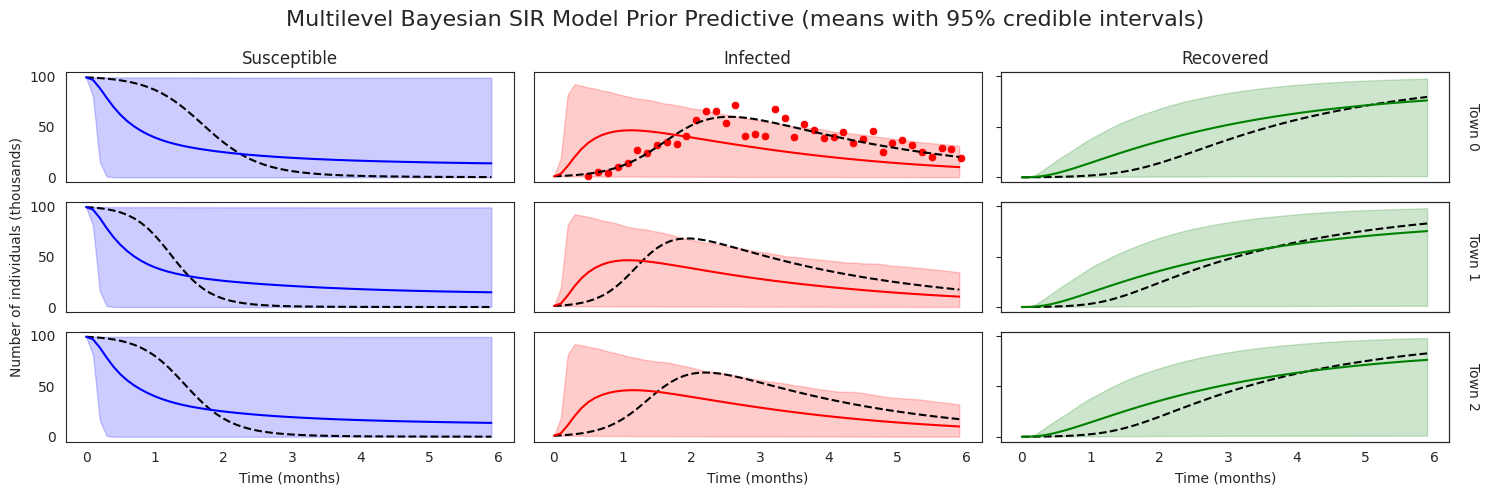

In [9]:
prior_predictive = Predictive(
    simulated_multilevel_bayesian_sir, num_samples=num_samples, parallel=True
)
prior_samples = prior_predictive(init_state, start_time, logging_times)

plot_sir_data(
    n_strata=n_strata,
    colors=colors,
    true_traj=sir_true_traj,
    true_logging_times=logging_times,
    sir_traj=prior_samples,
    logging_times=logging_times,
    sir_data=sir_data,
    obs_logging_times=obs_logging_times,
    main_title="Multilevel Bayesian SIR Model Prior Predictive (means with 95% credible intervals)",
)

We can see that without any data our prior has induced extremely broad uncertainty over resulting disease dynamics.

## Bayesian Partial Pooling with Dynamical Systems

### Probabilistic Inference over Dynamical System Parameters

One of the major benefits of writing our dynamical systems model in Pyro and ChiRho is that we can leverage Pyro's support for (partially) automated probabilistic inference. In this section we'll (i) condition on observational data using the `StaticBatchObservation` effect handler and (ii) optimize a variational approximation to the posterior using Pyro's SVI utilities.

In [10]:
def conditioned_sir(
    obs_times, data, init_state, start_time, base_model=SIRDynamics
) -> None:
    n_strata = init_state["S"].shape[-1]
    assert init_state["I"].shape[-1] == init_state["R"].shape[-1] == n_strata

    beta, gamma, _ = bayesian_multilevel_sir_prior(n_strata)
    sir = base_model(beta, gamma)

    obs = condition(data=data)(single_observation_model)
    with TorchDiffEq(), StaticBatchObservation(obs_times, observation=obs):
        simulate(sir, init_state, start_time, obs_times[-1])


# Define a helper function to run SVI.
# (Generally, Pyro users like to have more control over the training process!)
def run_svi_inference(
    model,
    num_steps=num_steps,
    verbose=True,
    lr=0.03,
    vi_family=AutoMultivariateNormal,
    guide=None,
    **model_kwargs
):
    if guide is None:
        guide = vi_family(model)
    elbo = pyro.infer.Trace_ELBO()(model, guide)
    # initialize parameters
    elbo(**model_kwargs)
    adam = torch.optim.Adam(elbo.parameters(), lr=lr)
    # Do gradient steps
    for step in range(1, num_steps + 1):
        adam.zero_grad()
        loss = elbo(**model_kwargs)
        loss.backward()
        adam.step()
        if (step % 25 == 0) or (step == 1) & verbose:
            print("[iteration %04d] loss: %.4f" % (step, loss))
    return guide

In [11]:
# Run inference to approximate the posterior distribution of the SIR model parameters
sir_guide = run_svi_inference(
    conditioned_sir,
    num_steps=num_steps,
    obs_times=obs_logging_times,
    data=sir_data,
    init_state=init_state,
    start_time=start_time,
)

[iteration 0001] loss: 375.4622
[iteration 0025] loss: 311.5026
[iteration 0050] loss: 247.8693
[iteration 0075] loss: 256.1041
[iteration 0100] loss: 248.2911
[iteration 0125] loss: 252.8723
[iteration 0150] loss: 252.9642
[iteration 0175] loss: 252.6111
[iteration 0200] loss: 249.2424


### Inspecting the posterior marginals

When we inspect the posterior mariginals, we see that our certainty decreased the most for Town 0. However, we also see that our estimates changed for other distributions as well.

In [12]:
# Generate samples from the posterior predictive distribution
sir_predictive = Predictive(
    simulated_multilevel_bayesian_sir,
    guide=sir_guide,
    num_samples=num_samples,
    parallel=True,
)
sir_posterior_samples = sir_predictive(init_state, start_time, logging_times)

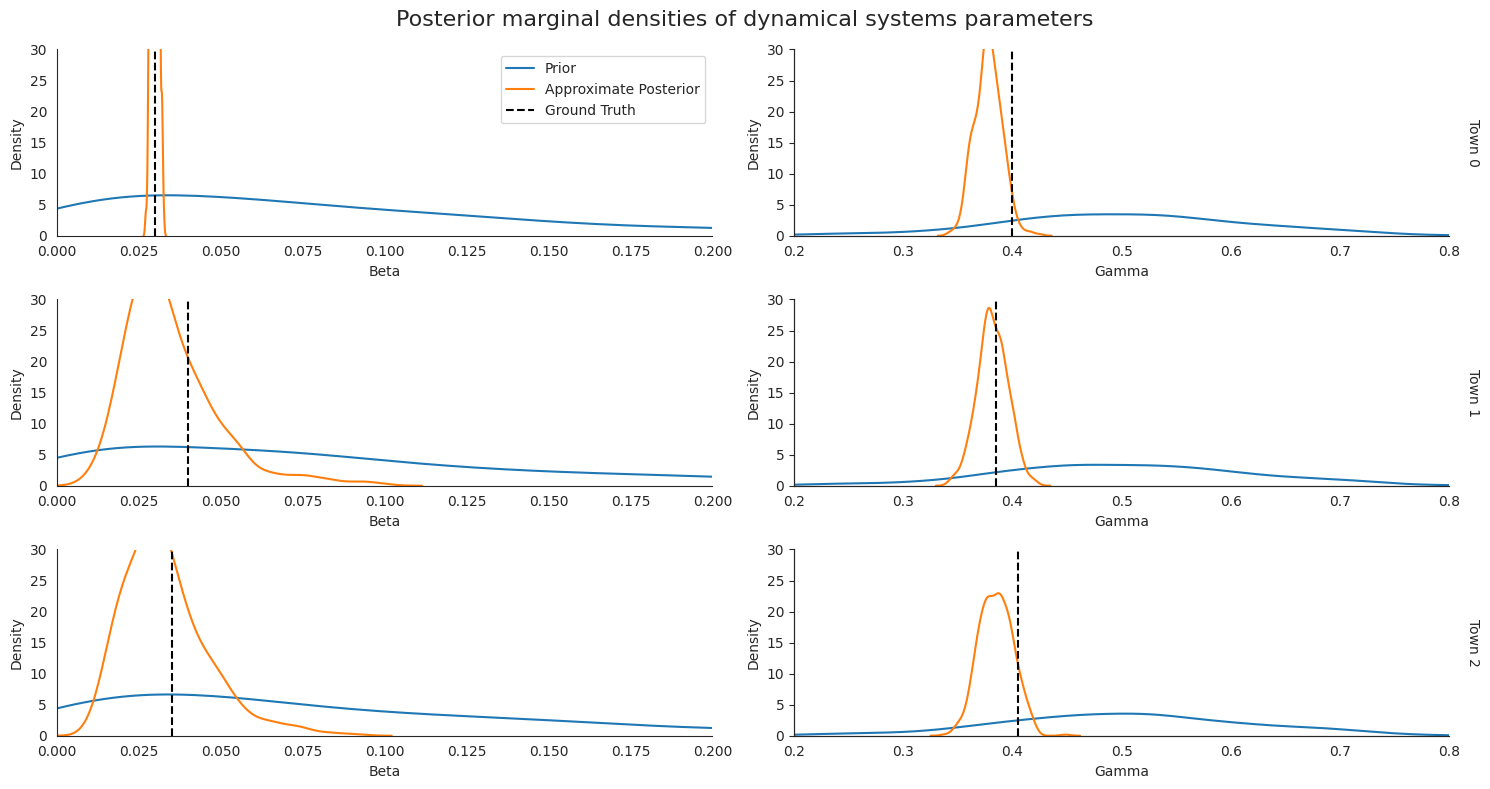

In [13]:
fig, ax = plt.subplots(n_strata, 2, figsize=(15, 8))

for i in range(n_strata):

    sns.kdeplot(prior_samples["beta"][..., i], label="Prior", ax=ax[i, 0])
    sns.kdeplot(sir_posterior_samples["beta"][..., i], label="Approximate Posterior", ax=ax[i, 0])
    ax[i, 0].axvline(beta_true[i], color="black", label="Ground Truth", linestyle="--")

#    ax[i, 0].set_yticks([])
    ax[i, 0].set_xlabel("Beta")
    ax[i, 0].set_xlim(0, 0.2)
    ax[i, 0].set_ylim(0, 30)

    ax[i, 0].set_ylabel("Density")

    sns.kdeplot(prior_samples["gamma"][..., i], ax=ax[i, 1])
    sns.kdeplot(sir_posterior_samples["gamma"][..., i], ax=ax[i, 1])
    ax[i, 1].axvline(gamma_true[i], color="black", linestyle="--")

    ax[i, 1].set_ylabel("Density")

#    ax[i, 1].set_yticks([])
    ax[i, 1].set_xlabel("Gamma")
    ax[i, 1].set_xlim(0.2, 0.8)
    ax[i, 1].set_ylim(0, 30)

    ax_right_1 = ax[i, 1].twinx()
    ax_right_1.set_ylabel(f"Town {i}", rotation=270, labelpad=15)
    ax_right_1.yaxis.set_label_position("right")
    ax_right_1.tick_params(right=False)
    ax_right_1.set_yticklabels([])


ax[0, 0].legend(loc="upper right")

fig.suptitle("Posterior marginal densities of dynamical systems parameters", fontsize=16)
plt.tight_layout()
sns.despine()
plt.show()

### Inspecting the posterior predictive distribution

Now that we've approximated the posterior distribution over parameters, let's see how the posterior samples compare to the ground truth parameters and disease trajectories. Notice also the uneven uncertainty decrease across towns.

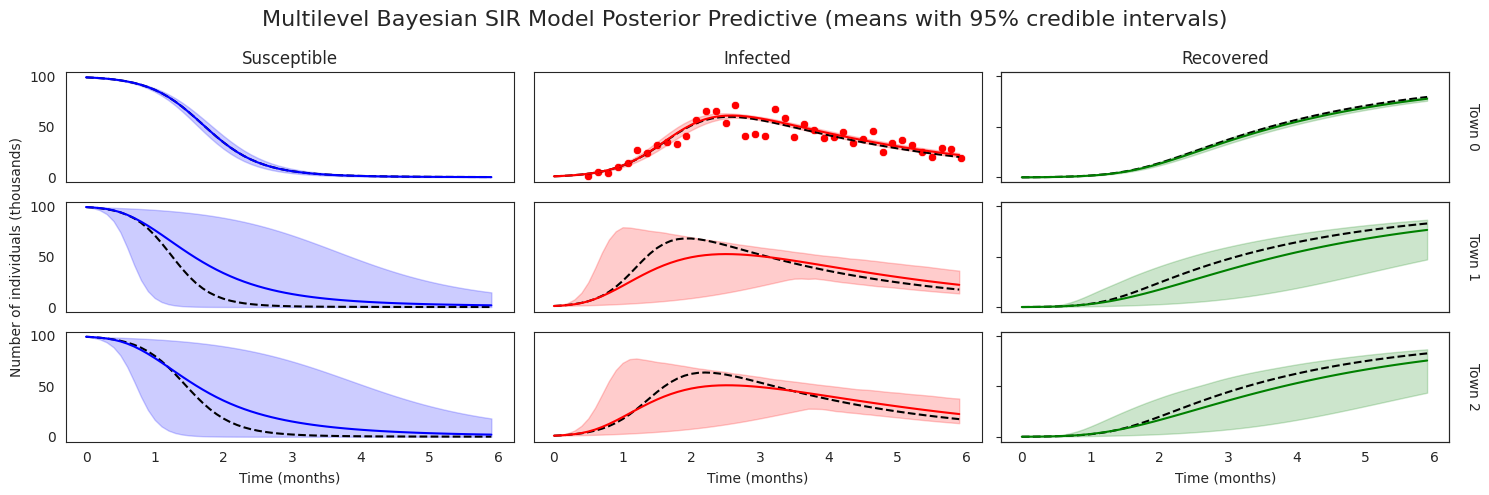

In [14]:
plot_sir_data(
    n_strata=n_strata,
    colors=colors,
    true_traj=sir_true_traj,
    true_logging_times=logging_times,
    sir_traj=sir_posterior_samples,
    logging_times=logging_times,
    sir_data=sir_data,
    obs_logging_times=obs_logging_times,
    main_title="Multilevel Bayesian SIR Model Posterior Predictive (means with 95% credible intervals)",
)

## Modeling Interventions

In [15]:
class SIRDynamicsLockdown(SIRDynamics):
    def __init__(self, beta0, gamma):
        super().__init__(beta0, gamma)
        self.beta0 = beta0

    def forward(self, X: State[torch.Tensor]):
        self.beta = (
            1 - X["l"]
        ) * self.beta0  # time-varing beta parametrized by lockdown strength l_t
        dX = super().forward(X)
        dX["l"] = torch.zeros_like(
            X["l"]
        )  # no dynamics for the lockdown strength unless intervened
        return dX


init_state_lockdown = dict(**init_state, l=torch.tensor(0.0))

In [16]:
def intervened_sir(
    lockdown_start, lockdown_strength, init_state, start_time, logging_times
) -> State[torch.Tensor]:
    n_strata = init_state["S"].shape[-1]
    assert init_state["I"].shape[-1] == init_state["R"].shape[-1] == n_strata
    beta, gamma, _ = bayesian_multilevel_sir_prior(n_strata)
    sir = SIRDynamicsLockdown(beta, gamma)
    with LogTrajectory(logging_times, is_traced=True) as lt:
        with TorchDiffEq():
            with StaticIntervention(
                time=lockdown_start, intervention=dict(l=lockdown_strength)
            ):
                simulate(sir, init_state, start_time, logging_times[-1])

    return lt.trajectory

In [17]:
lockdown_start = torch.tensor(1.0)
lockdown_strength = torch.tensor([0.7])

true_intervened_sir = pyro.condition(
    intervened_sir, data={"beta": beta_true, "gamma": gamma_true}
)
true_intervened_trajectory = true_intervened_sir(
    lockdown_start, lockdown_strength, init_state_lockdown, start_time, logging_times
)

intervened_sir_posterior_predictive = Predictive(
    intervened_sir, guide=sir_guide, num_samples=num_samples, parallel=True
)
intervened_sir_posterior_samples = intervened_sir_posterior_predictive(
    lockdown_start, lockdown_strength, init_state_lockdown, start_time, logging_times
)

intervened_sir_prior_predictive = Predictive(
    intervened_sir, num_samples=num_samples, parallel=True
)
intervened_sir_prior_samples = intervened_sir_prior_predictive(
    lockdown_start, lockdown_strength, init_state_lockdown, start_time, logging_times
)

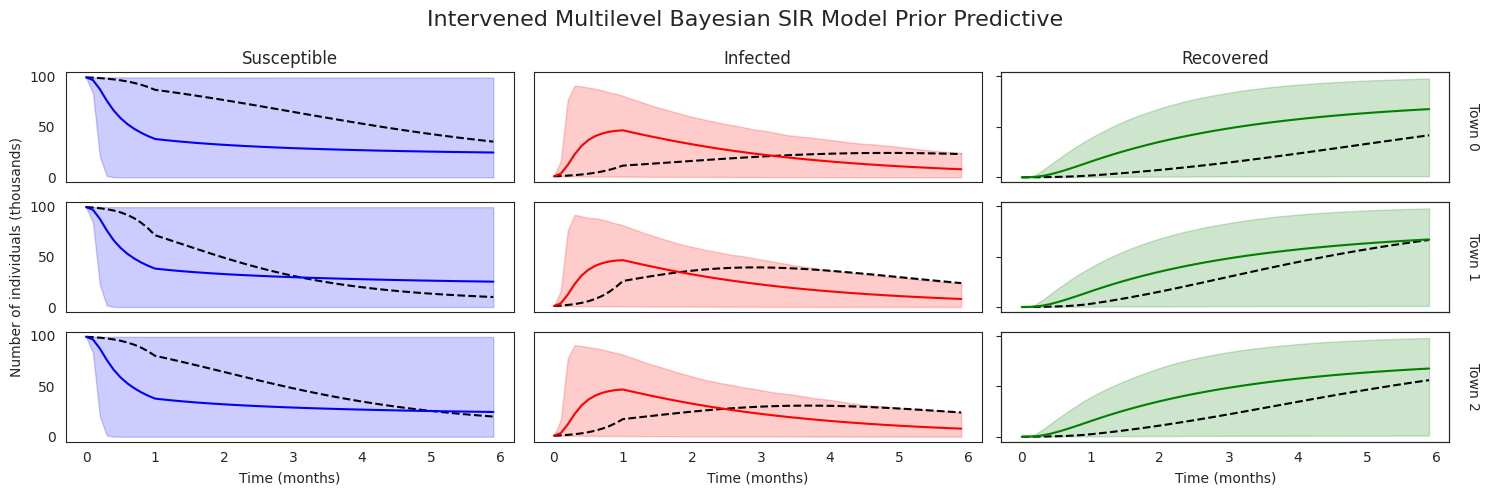

In [18]:
plot_sir_data(
    n_strata,
    colors=colors,
    true_traj=true_intervened_trajectory,
    true_logging_times=logging_times,
    sir_traj=intervened_sir_prior_samples,
    logging_times=logging_times,
    main_title="Intervened Multilevel Bayesian SIR Model Prior Predictive",
)

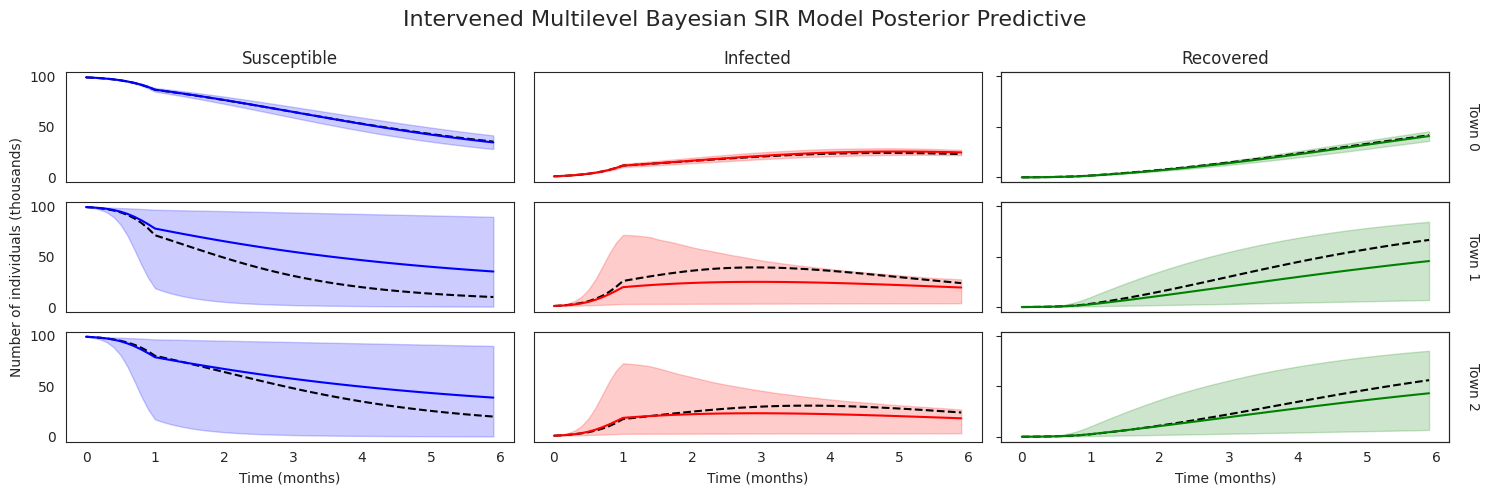

In [19]:
plot_sir_data(
    n_strata,
    colors=colors,
    true_traj=true_intervened_trajectory,
    true_logging_times=logging_times,
    sir_traj=intervened_sir_posterior_samples,
    logging_times=logging_times,
    main_title="Intervened Multilevel Bayesian SIR Model Posterior Predictive",
)


## Looking Forward: 
This tutorial is just one of many different ways ChiRho makes it easy to combine statistical techniques with mechanistic models. As non-exhaustive examples, one could instead assume that the mutual information between stratum-level parameters depends on geographic proximity, and/or extend the probabilistic program to regress stratum-level parameters on observed covariates. Our hope is that this and other examples inspire users to be creative, and to explore the rich spectrum between statistical and mechanistic modeling for scientific and policy applications.